# 05_comparacion_resultados — Consolidación Final

**Objetivo:** Comparar el desempeño de todos los modelos implementados en el set de validación (Dev Full).

**Modelos:**
1. **Baselines Triviales:** Majority, Stratified (Notebook 02)
2. **Baseline ML:** TF-IDF + SVM (Notebook 04)
3. **Transformers:** BETO, RoBERTa Bio, RoBERTa Clinical (Notebook 04)

**Métricas:** F1 Macro, Precision Macro, Recall Macro.

**Estrategia:** Weak Supervision (Train Denoised -> Dev Full).

In [5]:
# ===============================================================
# Setup: Imports y configuración
# ===============================================================
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Importar utilidades compartidas
try:
    from utils_shared import setup_paths
    paths = setup_paths()
    DATA_PATH = paths['DATA_PATH']
    FIGS_PATH = paths['FIGS_PATH']
    print("[OK] Usando utils_shared.py")
except ImportError:
    print("[ERROR] No se encontró utils_shared.py")
    raise

[OK] Usando utils_shared.py


## 1) Cargar Resultados

In [6]:
eval_files = {
    'Dummy Majority': DATA_PATH / 'dummy_majority_eval.csv',
    'Dummy Stratified': DATA_PATH / 'dummy_stratified_eval.csv',
    'TF-IDF + SVM': DATA_PATH / 'tfidf_eval.csv',
    'BETO': DATA_PATH / 'beto_eval.csv',
    'RoBERTa Bio': DATA_PATH / 'roberta_biomedical_eval.csv',
    'RoBERTa Clinical': DATA_PATH / 'roberta_clinical_eval.csv'
}

results = []
for name, path in eval_files.items():
    if path.exists():
        df = pd.read_csv(path)
        # Normalizar nombres de columnas si es necesario
        row = df.iloc[0].to_dict()
        row['Model'] = name
        results.append(row)
    else:
        print(f"[WARNING] No encontrado: {path.name}")

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('f1_macro', ascending=False)

print("\nTABLA CONSOLIDADA:")
display_cols = ['Model', 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy']
# Filtrar solo columnas que existen
display_cols = [c for c in display_cols if c in df_results.columns]
print(df_results[display_cols].to_markdown(index=False, floatfmt=".4f"))

# Guardar consolidado
df_results.to_csv(DATA_PATH / 'comparacion_modelos_consolidada.csv', index=False)


TABLA CONSOLIDADA:
| Model            |   f1_macro |   precision_macro |   recall_macro |   accuracy |
|:-----------------|-----------:|------------------:|---------------:|-----------:|
| BETO             |     0.8834 |            0.9000 |         0.8787 |     0.8868 |
| TF-IDF + SVM     |     0.8386 |            0.8679 |         0.8336 |     0.8453 |
| RoBERTa Bio      |     0.8229 |            0.8455 |         0.8187 |     0.8293 |
| RoBERTa Clinical |     0.7874 |            0.8288 |         0.7842 |     0.7990 |
| Dummy Stratified |     0.4878 |            0.5028 |         0.5023 |     0.5215 |
| Dummy Majority   |     0.3529 |            0.2727 |         0.5000 |     0.5455 |


## 2) Visualización Comparativa

Gráfico guardado en: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/comparacion_modelos_f1.png


/var/folders/25/fy01l91x3gj63g090ghxj7000000gn/T/ipykernel_74447/566724056.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x='f1_macro', y='Model', palette='viridis')


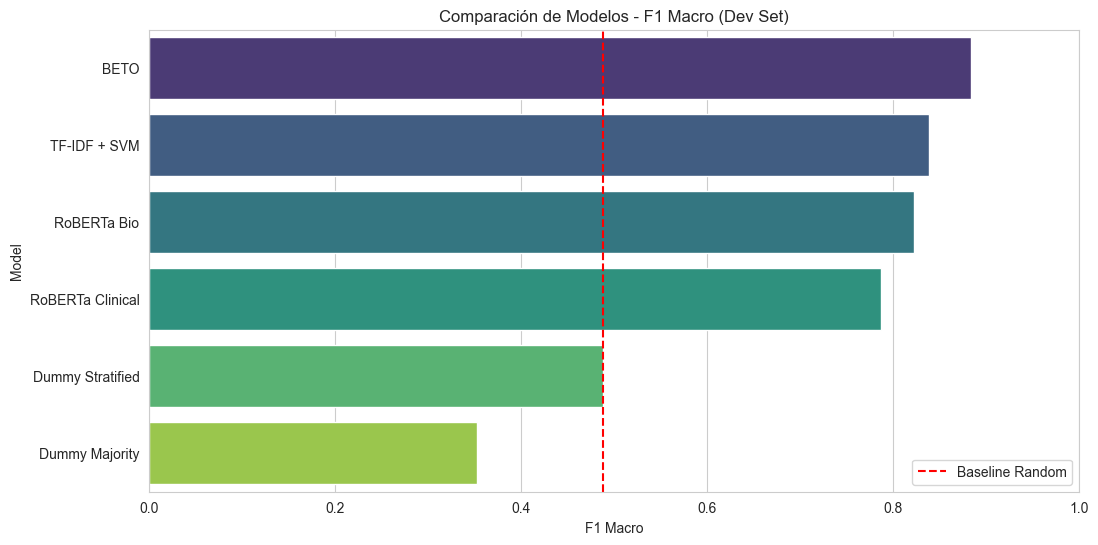

In [7]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x='f1_macro', y='Model', palette='viridis')
plt.title('Comparación de Modelos - F1 Macro (Dev Set)')
plt.xlabel('F1 Macro')
plt.xlim(0, 1.0)
plt.axvline(x=df_results[df_results['Model']=='Dummy Stratified']['f1_macro'].values[0], color='r', linestyle='--', label='Baseline Random')
plt.legend()

save_path = FIGS_PATH / 'comparacion_modelos_f1.png'
plt.savefig(save_path, bbox_inches='tight')
print(f"Gráfico guardado en: {save_path}")
plt.show()

## 3) Resultados Cross-Validation (Consolidado)

Análisis de los resultados obtenidos mediante 5-Fold CV.


TABLA RESUMEN CV (F1 Macro):
| Model            |   mean |    std |
|:-----------------|-------:|-------:|
| BETO             | 0.8414 | 0.0665 |
| TF-IDF + SVM     | 0.8242 | 0.0347 |
| Dummy Stratified | 0.4873 | 0.0145 |


/var/folders/25/fy01l91x3gj63g090ghxj7000000gn/T/ipykernel_74447/2669115909.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cv_all, x='f1_macro', y='Model', palette='viridis')


Gráfico guardado en: /Users/manuelnunez/Projects/psych-phenotyping-paraguay/data/figs/05_comparacion_cv_boxplot.png


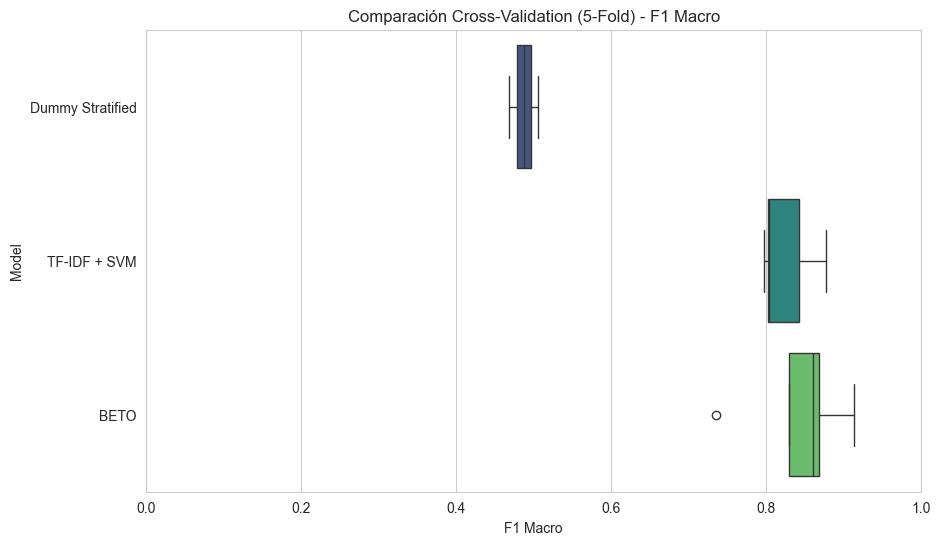

In [8]:
# Cargar resultados de CV
cv_files = {
    'Dummy Stratified': DATA_PATH / 'dummy_cv_results.csv',
    'TF-IDF + SVM': DATA_PATH / 'tfidf_cv_results.csv',
    'BETO': DATA_PATH / 'beto_cv_results.csv'
}

cv_data = []
for name, path in cv_files.items():
    if path.exists():
        df = pd.read_csv(path)
        df['Model'] = name
        cv_data.append(df)
    else:
        print(f"[WARNING] No encontrado: {path.name}")

if cv_data:
    df_cv_all = pd.concat(cv_data, ignore_index=True)
    
    # Calcular media y std
    summary = df_cv_all.groupby('Model')['f1_macro'].agg(['mean', 'std']).reset_index()
    summary = summary.sort_values('mean', ascending=False)
    
    print("\nTABLA RESUMEN CV (F1 Macro):")
    print(summary.to_markdown(index=False, floatfmt=".4f"))
    
    # Visualización
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_cv_all, x='f1_macro', y='Model', palette='viridis')
    plt.title('Comparación Cross-Validation (5-Fold) - F1 Macro')
    plt.xlabel('F1 Macro')
    plt.xlim(0, 1.0)
    
    save_path = FIGS_PATH / '05_comparacion_cv_boxplot.png'
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Gráfico guardado en: {save_path}")
    plt.show()
    
    # Guardar consolidado
    df_cv_all.to_csv(DATA_PATH / '05_comparacion_consolidada_cv.csv', index=False)
else:
    print("No hay resultados de CV disponibles.")